# **LSTM**

**Features**

In [2]:
!cp /content/drive/MyDrive/rossmann_dw.db /content/

In [6]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Sequential

# اتصال به دیتابیس
engine = create_engine('sqlite:///rossmann_dw.db')

# خواندن جدول‌ها
fact_sales = pd.read_sql('SELECT * FROM fact_sales', engine)
dim_store = pd.read_sql('SELECT * FROM dim_store', engine)
dim_date = pd.read_sql('SELECT * FROM dim_date', engine)

df_lstm = fact_sales.merge(dim_store, on='store_id', how='left')
df_lstm = df_lstm.merge(dim_date, on='date_id', how='left')

In [8]:
# log sales
df_lstm['log_sales'] = df_lstm['sales'].apply(lambda x: np.log1p(x))

# lag and rolling features
df_lstm.sort_values(['store_id', 'date_id'], inplace=True)

df_lstm['sales_lag_1'] = df_lstm.groupby('store_id')['sales'].shift(1)

df_lstm['rolling_mean_7'] = (
    df_lstm.groupby('store_id')['sales']
    .shift(1)
    .groupby(df_lstm['store_id'])
    .rolling(window=7)
    .mean()
    .reset_index(level=0, drop=True)
)

df_lstm['rolling_std_7'] = (
    df_lstm.groupby('store_id')['sales']
    .shift(1)
    .groupby(df_lstm['store_id'])
    .rolling(window=7)
    .std()
    .reset_index(level=0, drop=True)
)

df_lstm.dropna(inplace=True)

In [10]:
# one-hot encoding categorical features
categorical_cols = ['store_type', 'assortment_type', 'state_holiday']
df_lstm = pd.get_dummies(df_lstm, columns=categorical_cols, drop_first=True, dtype=int)

df_lstm.drop(columns=['customers', 'promo_interval'], axis=1, inplace=True)

In [11]:
df_lstm.columns

Index(['store_id', 'date_id', 'sales', 'promo', 'open', 'school_holiday',
       'competition_distance', 'competition_open_month',
       'competition_open_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'day', 'month', 'year', 'weekday', 'is_weekend',
       'log_sales', 'sales_lag_1', 'rolling_mean_7', 'rolling_std_7',
       'store_type_b', 'store_type_c', 'store_type_d', 'assortment_type_b',
       'assortment_type_c', 'state_holiday_a', 'state_holiday_b',
       'state_holiday_c'],
      dtype='object')

**Model Training**

In [12]:
# ---------- 1) تنظیمات ----------
seq_length = 42
batch_size = 512

train_end  = pd.to_datetime('2015-04-30')
val_start  = pd.to_datetime('2015-05-01')
val_end    = pd.to_datetime('2015-06-15')
test_start = pd.to_datetime('2015-06-16')
test_end   = pd.to_datetime('2015-07-31')

# ---------- 2) آماده‌سازی داده ----------
target = 'log_sales'
exclude_cols = ['log_sales', 'sales', 'date_id', 'store_id']
features = [c for c in df_lstm.columns if c not in exclude_cols]

df = df_lstm.copy()
df['date_id'] = pd.to_datetime(df['date_id'])
df = df.sort_values(['store_id','date_id']).reset_index(drop=True)

def to_float32(a):
    return np.asarray(a, dtype=np.float32, order='C')

# ---------- 3) سازنده دیتاستِ پنجره‌ای بدون متادیتا ----------
def make_range_dataset(df, features, target, start_date, end_date, seq_len=42, batch_size=512):
    """
    فقط نمونه‌هایی را می‌سازد که تاریخ y داخل [start_date, end_date] باشد.
    اگر start_date=None باشد، یعنی صرفاً سقف زمانی end_date داریم (مثل Train).
    """
    buf_start = (start_date - pd.Timedelta(days=seq_len-1)) if start_date is not None else None

    datasets = []
    for store_id, g in df.groupby('store_id', sort=False):
        if buf_start is None:
            g2 = g[g['date_id'] <= end_date]
        else:
            g2 = g[(g['date_id'] >= buf_start) & (g['date_id'] <= end_date)]
        if len(g2) < seq_len:
            continue

        X_mat = to_float32(g2[features].to_numpy())
        y_vec = to_float32(g2[target].to_numpy())
        t_arr = g2['date_id'].to_numpy('datetime64[ns]').astype('datetime64[ns]')

        N = len(g2)
        end_idx_all = np.arange(seq_len-1, N, dtype=np.int64)
        y_dates = t_arr[end_idx_all]

        if start_date is None:
            valid_mask = (y_dates <= end_date.to_datetime64())
        else:
            valid_mask = (y_dates >= start_date.to_datetime64()) & (y_dates <= end_date.to_datetime64())

        valid_ends = end_idx_all[valid_mask]
        if valid_ends.size == 0:
            continue

        F = X_mat.shape[1]

        def gen(x=X_mat, y=y_vec, ends=valid_ends, L=seq_len):
            for e in ends:
                s = e - (L - 1)
                yield x[s:e+1, :], y[e]

        ds_store = tf.data.Dataset.from_generator(
            gen,
            output_signature=(
                tf.TensorSpec(shape=(seq_len, F), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.float32),
            ),
        ).batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

        datasets.append(ds_store)

    if not datasets:
        return None
    ds_all = datasets[0]
    for d in datasets[1:]:
        ds_all = ds_all.concatenate(d)
    return ds_all

# ---------- 4) دیتاست‌ها ----------
train_ds = make_range_dataset(df, features, target, start_date=None,     end_date=train_end,  seq_len=seq_length, batch_size=batch_size)
val_ds   = make_range_dataset(df, features, target, start_date=val_start, end_date=val_end,   seq_len=seq_length, batch_size=batch_size)
test_ds  = make_range_dataset(df, features, target, start_date=test_start,end_date=test_end,  seq_len=seq_length, batch_size=batch_size)

# ---------- 5) نرمال‌سازی ----------
train_features_array = df.loc[df['date_id'] <= train_end, features].to_numpy(dtype=np.float32, copy=False)
norm = layers.Normalization(axis=-1)
norm.adapt(tf.data.Dataset.from_tensor_slices(train_features_array).batch(8192))

def map_normalize(x, y):
    return norm(x), y

train_ds_norm = train_ds.map(map_normalize, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_norm   = val_ds.map(map_normalize,   num_parallel_calls=tf.data.AUTOTUNE)
test_ds_norm  = test_ds.map(map_normalize,  num_parallel_calls=tf.data.AUTOTUNE)

# ---------- 6) مدل و آموزش ----------
model = Sequential([
    layers.Input(shape=(seq_length, len(features))),
    layers.LSTM(64),
    layers.Dense(1)
])

In [ ]:
model.compile(optimizer='adam', loss='mse')
model.fit(
    train_ds_norm,
    validation_data=val_ds_norm,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
)

In [ ]:
_ = model.evaluate(test_ds_norm, verbose=1)

1115/1115 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 0.0155


In [ ]:
model.save("/content/drive/MyDrive/backbone.keras")

In [13]:
model = tf.keras.models.load_model("/content/drive/MyDrive/backbone.keras", compile=False)

**Evaluation**

In [14]:
# ---------- 7) سازنده دیتاست با متادیتا ----------
def make_range_dataset_with_meta(df, features, target, start_date, end_date, seq_len=42, batch_size=512):
    buf_start = (start_date - pd.Timedelta(days=seq_len-1)) if start_date is not None else None
    datasets = []

    for store_id, g in df.groupby('store_id', sort=False):
        if buf_start is None:
            g2 = g[g['date_id'] <= end_date]
        else:
            g2 = g[(g['date_id'] >= buf_start) & (g['date_id'] <= end_date)]
        if len(g2) < seq_len:
            continue

        X_mat = g2[features].to_numpy(dtype=np.float32, copy=False)
        y_vec = g2[target].to_numpy(dtype=np.float32, copy=False)
        t_arr = g2['date_id'].to_numpy('datetime64[ns]')

        N = len(g2)
        end_idx_all = np.arange(seq_len-1, N, dtype=np.int64)
        y_dates = t_arr[end_idx_all]

        if start_date is None:
            valid_mask = (y_dates <= end_date.to_datetime64())
        else:
            valid_mask = (y_dates >= start_date.to_datetime64()) & (y_dates <= end_date.to_datetime64())

        valid_ends = end_idx_all[valid_mask]
        if valid_ends.size == 0:
            continue

        F = X_mat.shape[1]
        sid = np.int32(store_id)

        def gen2(x=X_mat, y=y_vec, ends=valid_ends, L=seq_len, dates=y_dates, sid_val=sid):
            for i, e in enumerate(ends):
                s = e - (L - 1)
                yield (
                    x[s:e+1, :].astype(np.float32),        # x
                    np.float32(y[e]),                      # y (log1p)
                    np.int32(sid_val),                     # store_id
                    np.int64(dates[i].astype('datetime64[ns]').astype('int64')),  # y_date_ns
                )

        ds_store = tf.data.Dataset.from_generator(
            gen2,
            output_signature=(
                tf.TensorSpec(shape=(seq_len, F), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32),
                tf.TensorSpec(shape=(), dtype=tf.int64),
            ),
        ).batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

        datasets.append(ds_store)

    if not datasets:
        return None
    ds_all = datasets[0]
    for d in datasets[1:]:
        ds_all = ds_all.concatenate(d)
    return ds_all

# دیتاست تست با متادیتا
test_ds_meta = make_range_dataset_with_meta(
    df, features, target,
    start_date=test_start, end_date=test_end,
    seq_len=seq_length, batch_size=batch_size
)

# ورودی‌های متادیتا را هم مثل مجموعه آموزش نرمال می‌کنیم تا با مدل هم‌تراز باشد
test_ds_meta_norm = test_ds_meta.map(
    lambda x, y, sid, dt: (norm(x), y, sid, dt),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf

def collect_preds_df(model, test_ds_meta, return_log_and_linear=True):
    preds_log, trues_log, stores, dates = [], [], [], []
    for xb, yb, sb, db in test_ds_meta:
        yhat_log = model.predict(xb, verbose=0).ravel()
        preds_log.extend(yhat_log.tolist())
        trues_log.extend(yb.numpy().ravel().tolist())
        stores.extend(sb.numpy().ravel().tolist())
        dates.extend(pd.to_datetime(db.numpy().ravel(), unit='ns').tolist())

    comp = pd.DataFrame({
        'store_id': stores,
        'date_id': dates,
        'y_true_log': trues_log,
        'y_pred_log': preds_log,
    }).sort_values(['store_id','date_id']).reset_index(drop=True)

    if return_log_and_linear:
        # برگرداندن به مقیاس فروش
        comp['y_true'] = np.expm1(comp['y_true_log'].to_numpy())
        comp['y_pred'] = np.expm1(comp['y_pred_log'].to_numpy())

    return comp

comp_test = collect_preds_df(model, test_ds_meta_norm)

rmse_all = np.sqrt(np.mean((comp_test['y_true'] - comp_test['y_pred'])**2))
mae_all  = np.mean(np.abs(comp_test['y_true'] - comp_test['y_pred']))
print(f"[Test on sales scale] RMSE: {rmse_all:.2f} | MAE: {mae_all:.2f}")

[Test on sales scale] RMSE: 1002.00 | MAE: 631.09


[LSTM Test] Store 1 | RMSE: 544.39 | MAE: 355.10 | Days: 46


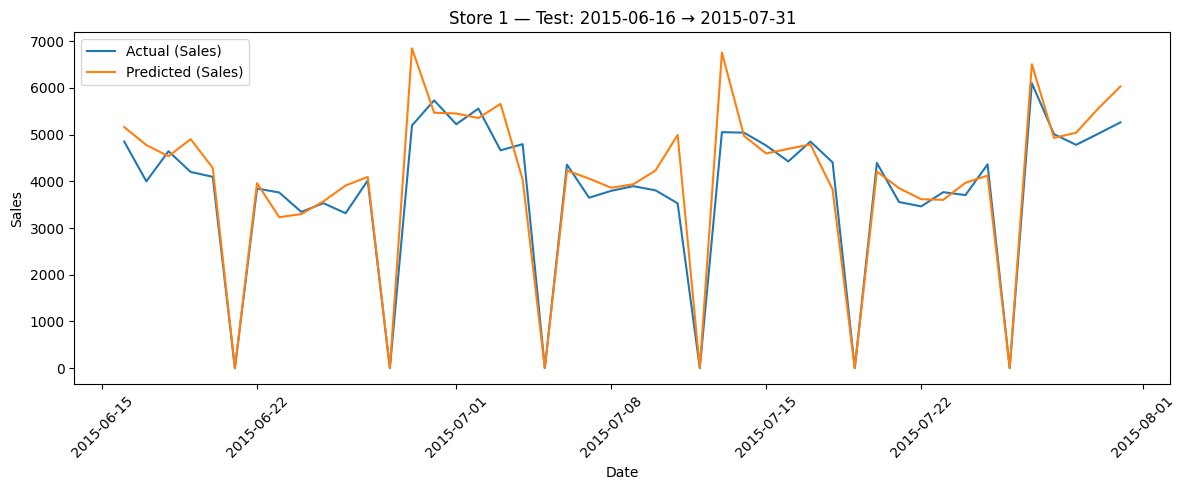

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lstm_test_store(comp_df, store_id, title_prefix="Store"):
    d = comp_df[comp_df['store_id'] == store_id].sort_values('date_id')
    if d.empty:
        raise ValueError(f'برای store_id={store_id} در بازه تست نمونه‌ای یافت نشد.')

    # متریک‌ها روی مقیاس فروش
    rmse = np.sqrt(np.mean((d['y_true'].to_numpy() - d['y_pred'].to_numpy())**2))
    mae  = np.mean(np.abs(d['y_true'].to_numpy() - d['y_pred'].to_numpy()))
    print(f"[LSTM Test] Store {store_id} | RMSE: {rmse:.2f} | MAE: {mae:.2f} | Days: {len(d)}")

    plt.figure(figsize=(12,5))
    plt.plot(d['date_id'], d['y_true'], label='Actual (Sales)')
    plt.plot(d['date_id'], d['y_pred'], label='Predicted (Sales)')
    plt.title(f"{title_prefix} {store_id} — Test: {pd.to_datetime(d['date_id'].min()).date()} → {pd.to_datetime(d['date_id'].max()).date()}")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return d

d = plot_lstm_test_store(comp_test, store_id=1)


In [16]:
# ==== RMSE / MAE per store_type ====

if 'y_true' not in comp_test.columns or 'y_pred' not in comp_test.columns:
    comp_test['y_true'] = np.expm1(comp_test['y_true_log'].to_numpy())
    comp_test['y_pred'] = np.expm1(comp_test['y_pred_log'].to_numpy())

# Map store_id -> store_type from dim_store
store_type_map = dim_store[['store_id', 'store_type']].drop_duplicates()

# Join and compute metrics
comp_by_type = (
    comp_test.merge(store_type_map, on='store_id', how='left')
             .assign(
                 abs_err=lambda d: (d['y_true'] - d['y_pred']).abs(),
                 sq_err =lambda d: (d['y_true'] - d['y_pred'])**2,
                 store_type=lambda d: d['store_type'].fillna('UNK')
             )
             .groupby('store_type', as_index=False, dropna=False)
             .agg(
                 n   =('y_true', 'size'),
                 MAE =('abs_err', 'mean'),
                 RMSE=('sq_err',  lambda x: np.sqrt(np.mean(x)))
             )
             .sort_values('RMSE', ascending=False)
)

comp_by_type

,store_type,n,MAE,RMSE
1,b,782,2165.632406,3031.525138
0,a,27692,586.213779,945.447961
3,d,16008,634.508594,934.939786
2,c,6808,629.306768,903.925884


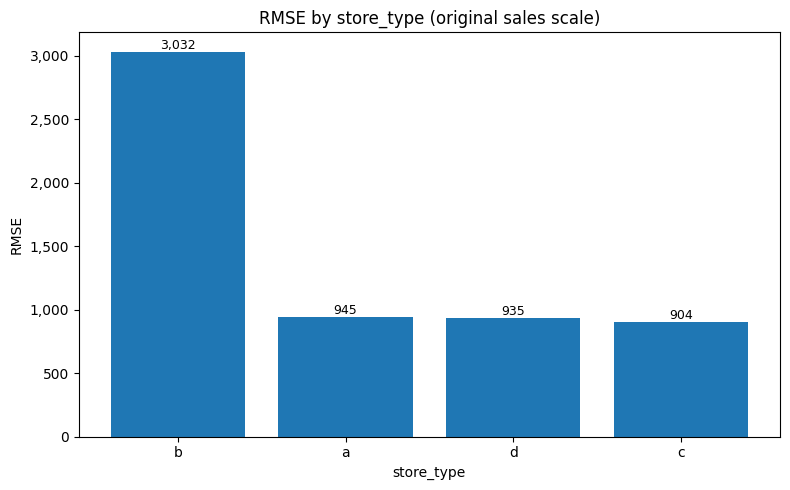

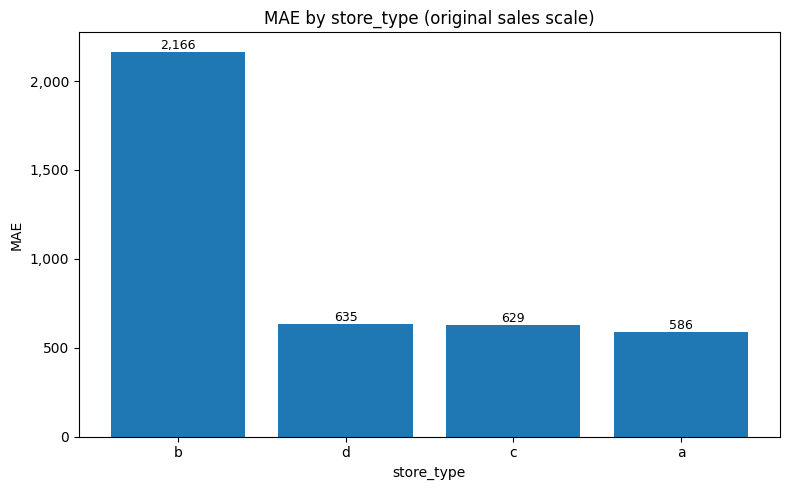

In [17]:
# ==== Plots: RMSE / MAE per store_type ====
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

fmt = FuncFormatter(lambda x, pos: f"{x:,.0f}")

# --- RMSE chart ---
comp_plot_rmse = comp_by_type.sort_values('RMSE', ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(comp_plot_rmse['store_type'].astype(str), comp_plot_rmse['RMSE'])
plt.gca().yaxis.set_major_formatter(fmt)
plt.title('RMSE by store_type (original sales scale)')
plt.xlabel('store_type')
plt.ylabel('RMSE')
plt.xticks(rotation=0)
# annotate bars
for i, v in enumerate(comp_plot_rmse['RMSE'].to_numpy()):
    plt.text(i, v, f"{v:,.0f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig('rmse_by_store_type.png', dpi=150)
plt.show()

# --- MAE chart ---
comp_plot_mae = comp_by_type.sort_values('MAE', ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(comp_plot_mae['store_type'].astype(str), comp_plot_mae['MAE'])
plt.gca().yaxis.set_major_formatter(fmt)
plt.title('MAE by store_type (original sales scale)')
plt.xlabel('store_type')
plt.ylabel('MAE')
plt.xticks(rotation=0)
# annotate bars
for i, v in enumerate(comp_plot_mae['MAE'].to_numpy()):
    plt.text(i, v, f"{v:,.0f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig('mae_by_store_type.png', dpi=150)
plt.show()


# **Future Prediction**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

def build_future_features_and_predict_v2(
    df,
    features,
    future_start,
    future_end,
    seq_length=42,
    model=None,
    norm=None,
    id_col='store_id',
    date_col='date_id',
    dtype_float=np.float32
):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    stores = df[id_col].unique()
    future_dates = pd.date_range(pd.to_datetime(future_start), pd.to_datetime(future_end), freq='D')

    # ---------- 1) فریم آینده ----------
    future = pd.MultiIndex.from_product([stores, future_dates], names=[id_col, date_col]).to_frame(index=False)

    # ---------- 2) استاتیک‌ها (از آخرین مقدار هر فروشگاه) ----------
    static_cols = [
        'competition_distance','competition_open_month','competition_open_year',
        'promo2','promo2_since_week','promo2_since_year',
        'store_type_b','store_type_c','store_type_d',
        'assortment_type_b','assortment_type_c'
    ]
    static_available = [c for c in static_cols if c in df.columns]
    if static_available:
        static_map = df[[id_col] + static_available].drop_duplicates(id_col, keep='last')
        future = future.merge(static_map, on=id_col, how='left')

    # ---------- 3) تقویمی‌های پایه ----------
    di = pd.to_datetime(future[date_col])
    future['day']       = di.dt.day.astype(np.int8) if 'day' in features else 0
    future['month']     = di.dt.month.astype(np.int8) if 'month' in features else 0
    future['year']      = di.dt.year.astype(np.int16) if 'year' in features else 0
    future['weekday']   = di.dt.weekday.astype(np.int8) if 'weekday' in features else 0
    future['is_weekend']= (future['weekday']>=5).astype(np.int8) if 'is_weekend' in features else 0

    # ---------- 4) کپی از سال قبل برای سیگنال‌های روزانه ----------
    copy_cols = [c for c in ['promo','open','school_holiday',
                             'state_holiday_a','state_holiday_b','state_holiday_c']
                 if c in df.columns]
    future['__date_prev'] = future[date_col] - pd.Timedelta(days=364)
    if copy_cols:
        hist = df[[id_col, date_col] + copy_cols].copy()
        hist[date_col] = pd.to_datetime(hist[date_col])
        future = future.merge(hist.rename(columns={date_col: '__date_prev'}),
                              on=[id_col, '__date_prev'], how='left', suffixes=('','_prev'))
    # مقادیر پیش‌فرض
    if 'open' in features:
        future['open'] = future['open'].fillna(1).astype(np.int8) if 'open' in future.columns else 1
    for c in ['promo','school_holiday','state_holiday_a','state_holiday_b','state_holiday_c']:
        if c in features:
            future[c] = future.get(c, 0)
            future[c] = future[c].fillna(0).astype(np.int8)

    future.drop(columns=['__date_prev'], inplace=True, errors='ignore')

    # ---------- 5) الحاق به df ----------
    for k in ['sales','log_sales','y_pred','y_pred_log']:
        if k not in future.columns:
            future[k] = np.nan
    df_ext = pd.concat([df, future], ignore_index=True)
    df_ext.sort_values([id_col, date_col], inplace=True)
    df_ext.reset_index(drop=True, inplace=True)

    if 'sales_signal' not in df_ext.columns:
        df_ext['sales_signal'] = df_ext['sales']

    # ---------- 6) حلقهٔ autoregressive برای هر روز آینده ----------
    df_ext.set_index([id_col, date_col], inplace=True)
    df_ext.sort_index(inplace=True)

    for d in future_dates:
        for sid in stores:
            key_today = (sid, d)

            if 'sales_lag_1' in features:
                prev_key = (sid, d - pd.Timedelta(days=1))
                lag1 = df_ext.at[prev_key, 'sales_signal'] if prev_key in df_ext.index else np.nan
                df_ext.at[key_today, 'sales_lag_1'] = np.float32(lag1) if pd.notna(lag1) else np.nan

            idx7 = [(sid, d - pd.Timedelta(days=k)) for k in range(1, 8)]
            vals7 = [df_ext.at[i, 'sales_signal'] for i in idx7
                     if i in df_ext.index and pd.notna(df_ext.at[i, 'sales_signal'])]

            if 'rolling_mean_7' in features:
                df_ext.at[key_today, 'rolling_mean_7'] = np.float32(np.mean(vals7)) if len(vals7) >= 1 else np.nan
            if 'rolling_std_7' in features:
                df_ext.at[key_today, 'rolling_std_7']  = np.float32(np.std(vals7, ddof=0)) if len(vals7) >= 2 else 0.0

            if (model is not None) and (norm is not None):
                start_win = d - pd.Timedelta(days=seq_length-1)
                try:
                    Xwin = df_ext.loc[(sid, slice(start_win, d)), features]
                    if len(Xwin) == seq_length and not Xwin.isnull().values.any():
                        xb = Xwin.to_numpy(dtype=dtype_float, copy=False)[None, :, :]
                        xb = tf.convert_to_tensor(xb, dtype=tf.float32)
                        xb = norm(xb)
                        yhat_log = float(model.predict(xb, verbose=0).ravel()[0])
                        yhat = float(np.expm1(yhat_log))
                        df_ext.at[key_today, 'y_pred_log']  = yhat_log
                        df_ext.at[key_today, 'y_pred']      = yhat
                        df_ext.at[key_today, 'sales_signal'] = yhat
                except KeyError:
                    pass

    df_ext = df_ext.reset_index()

    for f in features:
        if f not in df_ext.columns:
            df_ext[f] = np.nan

    return df_ext

In [ ]:
future_start = pd.to_datetime(df['date_id']).max() + pd.Timedelta(days=1)
future_end   = future_start + pd.Timedelta(days=29)

df_future = build_future_features_and_predict_v2(
    df=df,
    features=features,
    future_start=future_start,
    future_end=future_end,
    seq_length=seq_length,
    model=model,
    norm=norm
)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

def make_forecast_dataset(df, features, forecast_start, forecast_end, seq_len=42, batch_size=512):

    buf_start = forecast_start - pd.Timedelta(days=seq_len-1)
    datasets = []

    for store_id, g in df.groupby('store_id', sort=False):
        g2 = g[(g['date_id'] >= buf_start) & (g['date_id'] <= forecast_end)]
        if len(g2) < seq_len:
            continue

        X_mat = g2[features].to_numpy(dtype=np.float32, copy=False)
        t_arr = g2['date_id'].to_numpy('datetime64[ns]')

        N = len(g2)
        end_idx_all = np.arange(seq_len-1, N, dtype=np.int64)
        y_dates = t_arr[end_idx_all]

        valid_mask = (y_dates >= forecast_start.to_datetime64()) & (y_dates <= forecast_end.to_datetime64())
        valid_ends = end_idx_all[valid_mask]
        if valid_ends.size == 0:
            continue

        F = X_mat.shape[1]
        sid = np.int32(store_id)

        def gen(x=X_mat, ends=valid_ends, L=seq_len, dates=y_dates, sid_val=sid):
            for i, e in enumerate(ends):
                s = e - (L - 1)
                yield x[s:e+1, :].astype(np.float32), np.int32(sid_val), np.int64(dates[i].astype('datetime64[ns]').astype('int64'))

        ds_store = tf.data.Dataset.from_generator(
            gen,
            output_signature=(
                tf.TensorSpec(shape=(seq_len, F), dtype=tf.float32),  # x
                tf.TensorSpec(shape=(), dtype=tf.int32),              # store_id
                tf.TensorSpec(shape=(), dtype=tf.int64),              # y_date_ns
            ),
        )

        ds_store = ds_store.batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)
        datasets.append(ds_store)

    if not datasets:
        return None

    ds_all = datasets[0]
    for d in datasets[1:]:
        ds_all = ds_all.concatenate(d)
    return ds_all


def forecast_range(df, features, model, norm, forecast_start, forecast_end, seq_len=42, batch_size=512):

    ds = make_forecast_dataset(df, features, forecast_start, forecast_end, seq_len=seq_len, batch_size=batch_size)
    if ds is None:
        raise ValueError("پنجره‌ی کافی برای ساخت توالی‌ها در این بازه وجود ندارد. مطمئن شو فیچرهای تاریخ‌های آینده در df موجودند.")

    ds_norm = ds.map(lambda x, sid, dt: (norm(x), sid, dt), num_parallel_calls=tf.data.AUTOTUNE)

    preds_log, stores, dates = [], [], []
    for xb, sb, db in ds_norm:
        yhat_log = model.predict(xb, verbose=0).ravel()
        preds_log.extend(yhat_log.tolist())
        stores.extend(sb.numpy().ravel().tolist())
        dates.extend(pd.to_datetime(db.numpy().ravel(), unit='ns').tolist())

    out = pd.DataFrame({
        'store_id': stores,
        'date_id': dates,
        'y_pred_log': preds_log,
    }).sort_values(['store_id','date_id']).reset_index(drop=True)

    # تبدیل به فروش
    out['y_pred'] = np.expm1(out['y_pred_log'].to_numpy())
    return out


def forecast_next_week(df, features, model, norm, seq_len=42, batch_size=512, start_day=None):

    if start_day is None:
        start_day = pd.to_datetime(df['date_id']).max() + pd.Timedelta(days=1)
    start_day = future_start
    end_day   = future_end

    return forecast_range(
        df=df, features=features, model=model, norm=norm,
        forecast_start=start_day, forecast_end=end_day,
        seq_len=seq_len, batch_size=batch_size
    )

predictions = forecast_next_week(df_future, features, model, norm, seq_len=seq_length, batch_size=batch_size)
predictions

,store_id,date_id,y_pred_log,y_pred
0,1,2015-08-01,8.338117,4179.209508
1,1,2015-08-02,0.071922,0.074571
2,1,2015-08-03,8.752644,6326.393021
3,1,2015-08-04,8.539427,5111.413105
4,1,2015-08-05,8.478005,4806.850632
...,...,...,...,...
33445,1115,2015-08-26,8.583305,5340.732721
33446,1115,2015-08-27,8.675275,5855.309166
33447,1115,2015-08-28,8.828371,6824.159897
33448,1115,2015-08-29,8.966653,7836.325110


In [ ]:
predictions['y_pred'] = predictions['y_pred'].apply(lambda x: 0 if -1 < x < 1 else x)
predictions.drop(columns=['y_pred_log'], inplace=True)
predictions

,store_id,date_id,y_pred
0,1,2015-08-01,4179.209508
1,1,2015-08-02,0.000000
2,1,2015-08-03,6326.393021
3,1,2015-08-04,5111.413105
4,1,2015-08-05,4806.850632
...,...,...,...
33445,1115,2015-08-26,5340.732721
33446,1115,2015-08-27,5855.309166
33447,1115,2015-08-28,6824.159897
33448,1115,2015-08-29,7836.325110


In [ ]:
predictions.to_csv("lstm_predictions.csv", index=False)

In [ ]:
!cp /content/lstm_predictions.csv /content/drive/MyDrive/